In [1]:
import re
import math
import pickle
import requests
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from time import time
import IPython.display as Disp
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from underthesea import word_tokenize
from operator import itemgetter
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('2k_data_Sep.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feedback ID      2000 non-null   float64
 1   Lookup Text      2000 non-null   object 
 2   Question Text    2000 non-null   object 
 3   Feedback Type    2000 non-null   object 
 4   Feedback Result  2000 non-null   object 
 5   Human Feedback   2000 non-null   object 
 6   Lookup Image     2000 non-null   object 
 7   Question Image   2000 non-null   object 
dtypes: float64(1), object(7)
memory usage: 125.1+ KB


In [3]:
def clean_function(text):  
    #lowercase
    text = text.lower()
    
#     #xoá ký tự đặc biệt, ký tự không phải alphanumeric 
#     text = re.sub("[^a-z0-9àáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễòóọỏõôồốộổỗơờớợởỡìíịỉĩùúụủũưừứựửữỳýỵỷỹđ]",' ', text)
    
#     #xoá leading zero
#     text = [e.lstrip('0') for e in text.split(' ')]
#     text = (' ').join(text)
    
    #replace extra spaces with single space
    text = re.sub(' +',' ',text)
    
    #xoá khoảng trắng ở đầu và cuối mỗi câu
    text = text.strip()
    
    #word tokenzie
    text = word_tokenize(text, format='text')
    return text

In [4]:
df['index_org'] = df.index

df['clean_lookup'] = df['Lookup Text'].map(lambda x: clean_function(x))
df['clean_question'] = df['Question Text'].map(lambda x: clean_function(x))

df['char_count_lookup'] = df['clean_lookup'].str.len()
df['word_count_lookup'] = df['clean_lookup'].str.split().str.len()
df['average_word_length_lookup'] = df['char_count_lookup'] / df['word_count_lookup']

df['char_count_question'] = df['clean_question'].str.len()
df['word_count_question'] = df['clean_question'].str.split().str.len()
df['average_word_length_question'] = df['char_count_question'] / df['word_count_question']

In [5]:
check_dup = df[['Lookup Text', 'Question Text']][df[['Lookup Text', 'Question Text']].duplicated()]
df = df.drop(check_dup.index)
df = df.reset_index(drop = True)
df.shape

(1962, 17)

In [6]:
mask1 = df['Human Feedback'] == 'NOT MATCH'
mask2 = df['Human Feedback'] == 'MATCH'

df_neg = df[mask1].reset_index(drop = True)
df_pos = df[mask2].reset_index(drop = True)

print(df_neg.shape)
print(df_pos.shape)

(966, 17)
(996, 17)


In [7]:
df['diff_word'] = abs(df['word_count_question'] - df['word_count_lookup'])
df_neg['diff_word'] = abs(df_neg['word_count_question'] - df_neg['word_count_lookup'])
df_pos['diff_word'] = abs(df_pos['word_count_question'] - df_pos['word_count_lookup'])

my_bins = [-np.inf, 5, 10, 15, 20, np.inf]
my_labels = ['Very low', 'Low', 'Medium', 'High', 'Very high']

df['diff_bin'] = pd.cut(df['diff_word'], bins=my_bins, labels=my_labels)
df_neg['diff_bin'] = pd.cut(df_neg['diff_word'], bins=my_bins, labels=my_labels)
df_pos['diff_bin'] = pd.cut(df_pos['diff_word'], bins=my_bins, labels=my_labels)

In [8]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    vn_stop_words = file.read()
vn_stop_words = vn_stop_words.split('\n') 

# combine Vietnamese stopwords and English stopwords
stop_words = ENGLISH_STOP_WORDS.union(vn_stop_words)

In [9]:
def jaccard_search(query, data, top_result = 5, check_time = True):
#     #Load data
#     df_product = pd.read_csv('data/product_names_clean.csv', index_col=0)
    
    t0=time()
    results = pd.DataFrame(columns=['lookup_text', 'question_text', 'j_score', 
                                    'jc_word_count_question', 'jc_diff_bin', 'jc_image'])
    
    q = clean_function(query)
    words_doc1 = set(q.lower().split()) 
    
    for i in range(data.shape[0]):
        words_doc2 = set(data.iloc[i]['clean_question'].lower().split())

        # Find the intersection of words list of doc1 & doc2
        intersection = words_doc1.intersection(words_doc2)

        # Find the union of words list of doc1 & doc2
        union = words_doc1.union(words_doc2)

        # Calculate Jaccard similarity score 
        # using length of intersectioEm n set divided by length of union set
        jaccard_score = len(intersection) / len(union)
        result = pd.DataFrame({'lookup_text': query,
                               'question_text': [data.iloc[i]['Question Text']],
                               'j_score': jaccard_score,
                               'jc_word_count_question': [data.iloc[i]['word_count_question']],
                               'jc_diff_bin': [data.iloc[i]['diff_bin']],
                               'jc_image': [data.iloc[i]['Question Image']]})
        results = pd.concat([results,result], axis=0).sort_values('j_score', ascending=False)[:top_result]
    times = time() - t0
    if check_time:
        if times < 60:
            print('Jaccard search took {:.2f}s.'.format(times))
        else:
            print('Jaccard search took {:.2f} minutes.'.format(times / 60))
    return results

In [10]:
df_results = pd.DataFrame(columns = ['lookup_text', 'question_text', 'j_score', 
                                      'jc_word_count_question', 'jc_diff_bin', 'jc_image'])

queries = df['Lookup Text']

t0 = time()
for q in queries:
    results = jaccard_search(q, df, check_time = False).head(1)
    df_results = pd.concat([df_results, results], axis = 0)
print('Jaccard search took: {:.2f} minutes.'.format((time() - t0) / 60))

Jaccard search took: 113.10 minutes.


In [11]:
df_results.reset_index(drop = True, inplace = True)

df['search_result'] = df_results['question_text']
df['jc_score'] = df_results['j_score']
df['jc_word_count_question'] = df_results['jc_word_count_question']
df['jc_diff_bin'] = df_results['jc_diff_bin']
df['jc_image'] = df_results['jc_image']

In [12]:
mask1 = df['Human Feedback'] == 'MATCH'
mask2 = df['Question Text'] == df['search_result']
mask3 = df['Lookup Text'] == df['search_result']

df_match = df[mask1 & (mask2 | mask3)]
df_match.shape

(950, 24)

In [13]:
not_index = [x for x in df.index if x not in df_match.index]
df_not = df.iloc[not_index, :]
df_not.shape

(1012, 24)

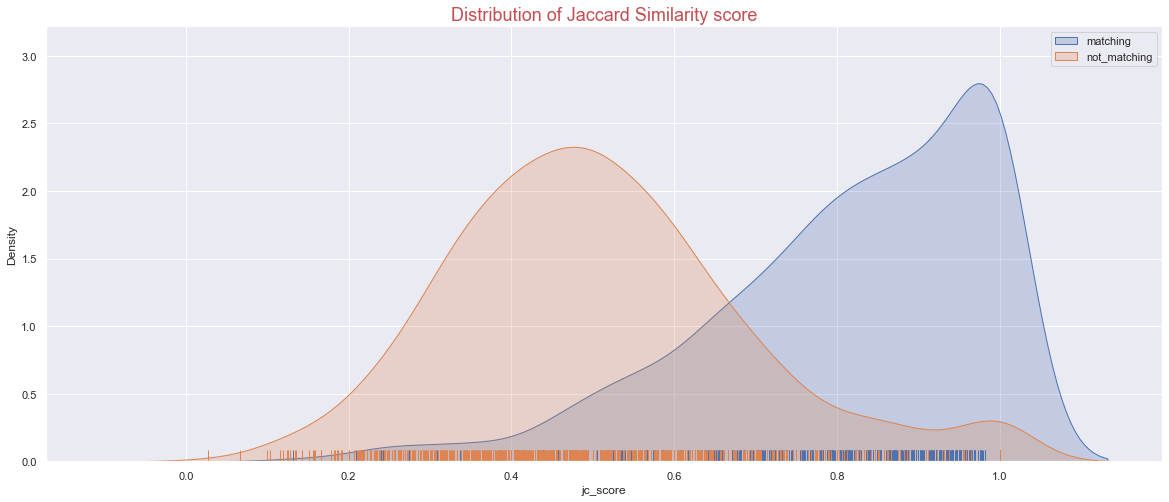

In [14]:
sb.set_theme()
plt.figure(figsize=(20, 8))
sb.distplot(df_match.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'matching')
sb.distplot(df_not.jc_score, hist = False, rug = True, kde_kws={'shade':'kde_kws'},label = 'not_matching')
plt.legend()
plt.title('Distribution of Jaccard Similarity score', fontsize = 18, color = 'r');

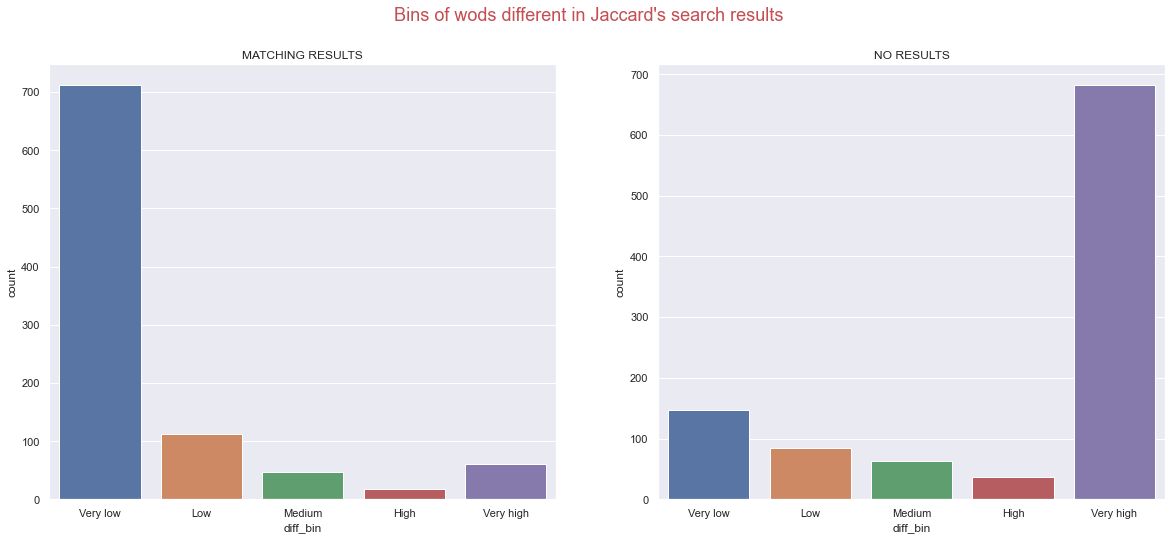

In [15]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
sb.countplot(df_match['diff_bin'])
plt.title('MATCHING RESULTS')
plt.subplot(122)
sb.countplot(df_not['diff_bin'])
plt.title('NO RESULTS')
plt.suptitle("Bins of wods different in Jaccard's search results", fontsize = 18, color = 'r');

In [22]:
df_not = df_not.sort_values(by = 'jc_score', ascending = False)

PAIRS: 1 - Jaccard score: 1.0
-- Number of words: 53


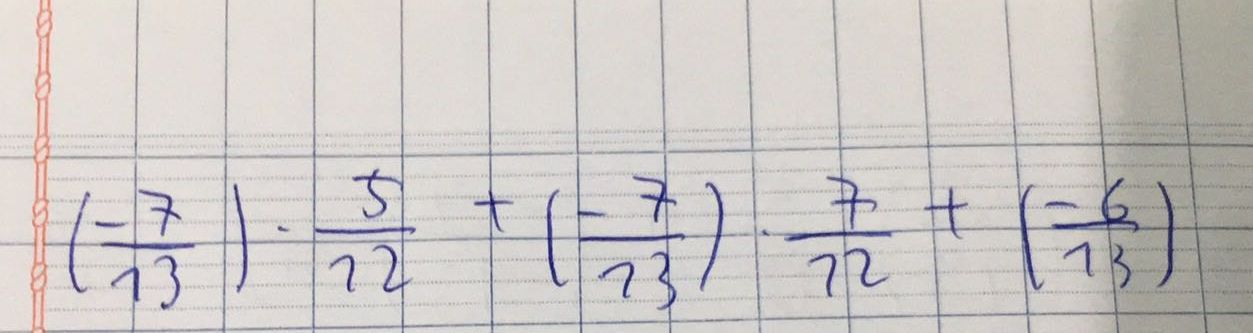

-- Number of words: 297


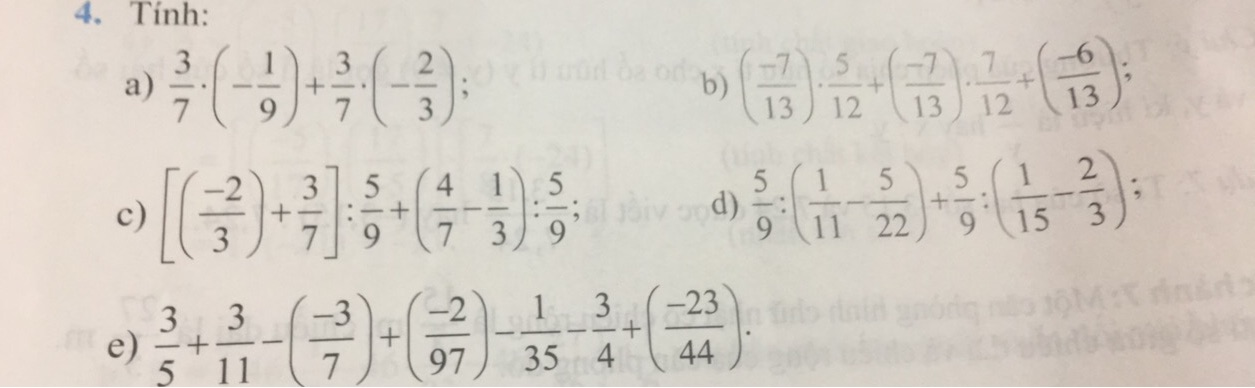

-- Number of words: 53


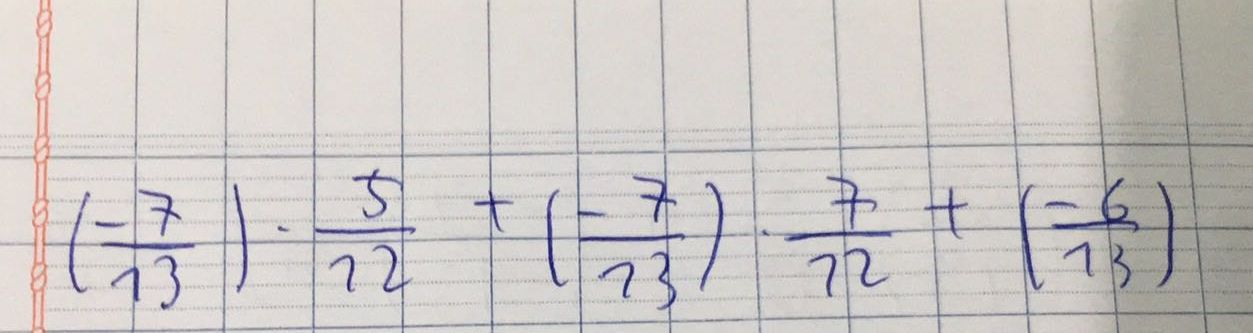

************

PAIRS: 2 - Jaccard score: 1.0
-- Number of words: 154


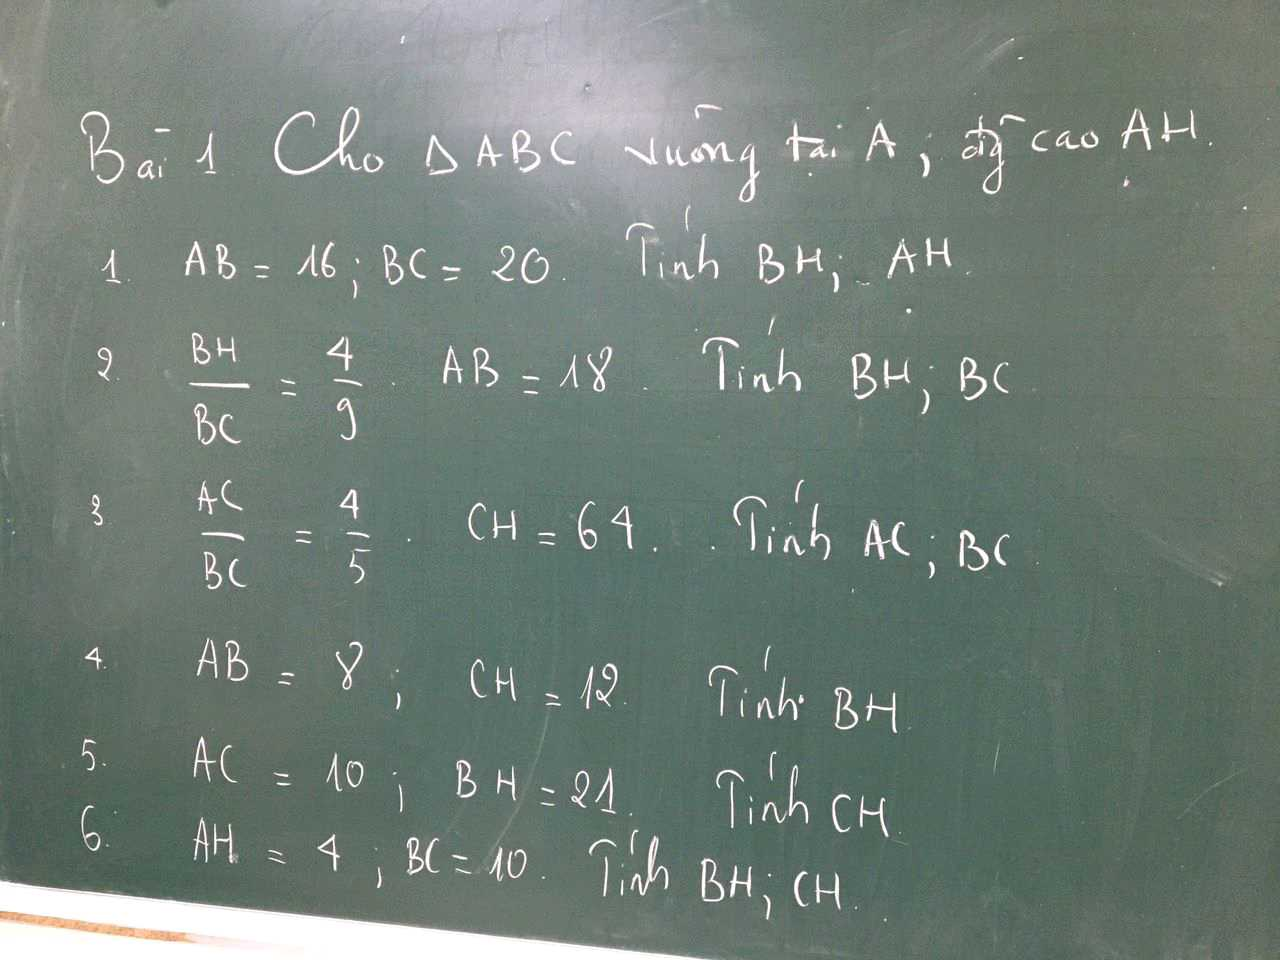

-- Number of words: 141


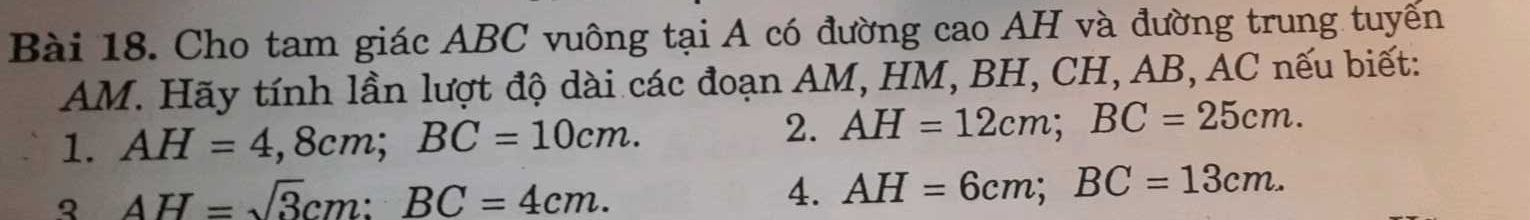

-- Number of words: 154


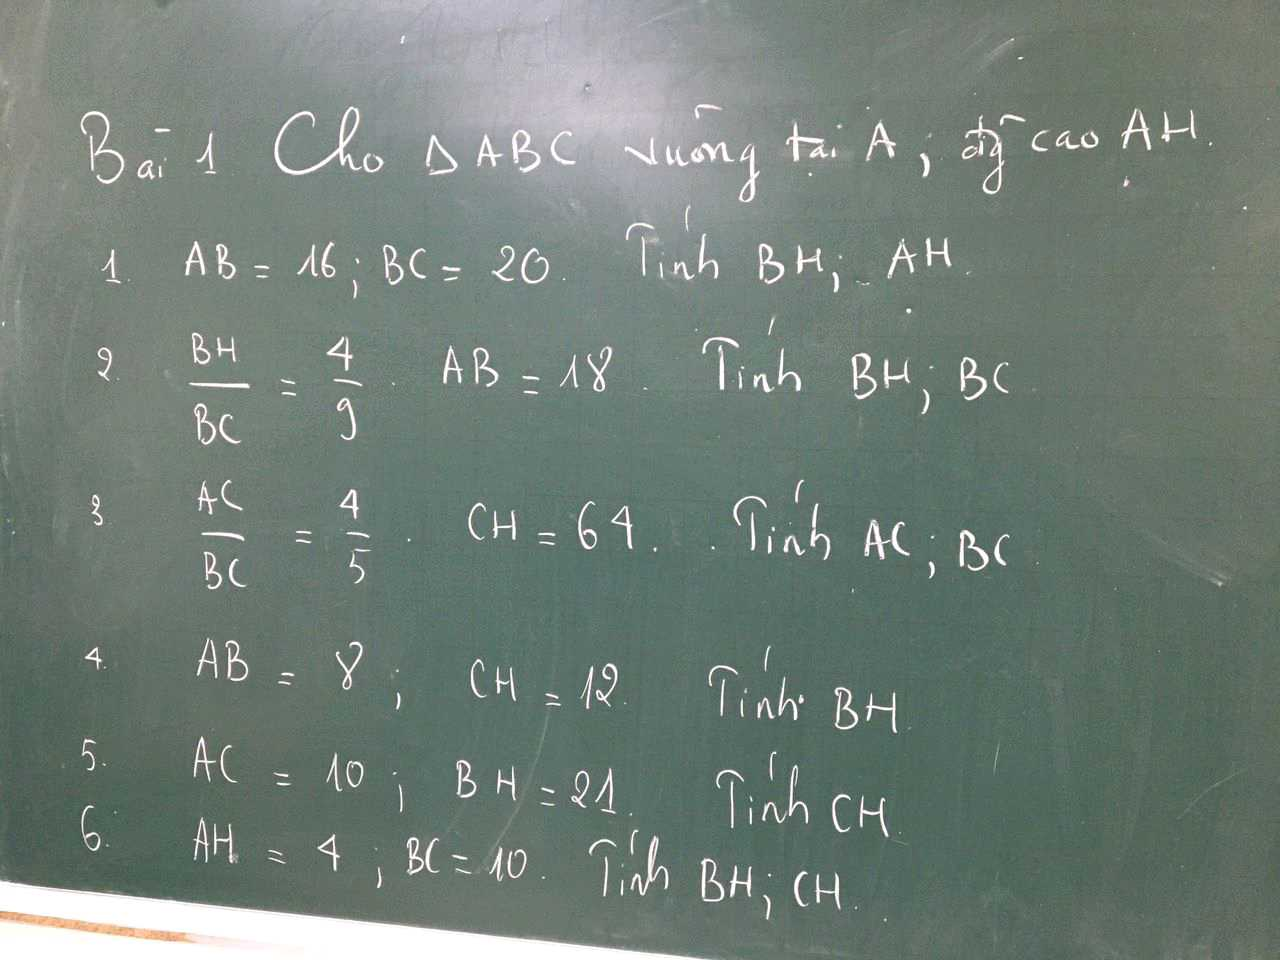

************

PAIRS: 3 - Jaccard score: 1.0
-- Number of words: 58


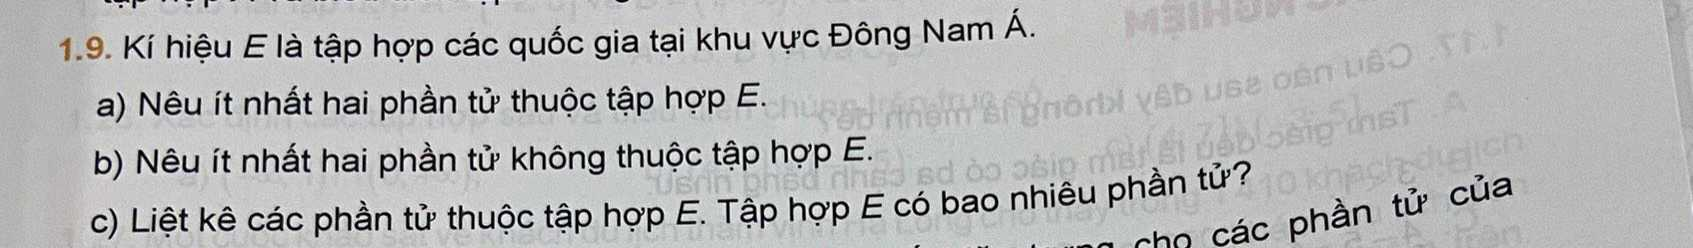

-- Number of words: 117


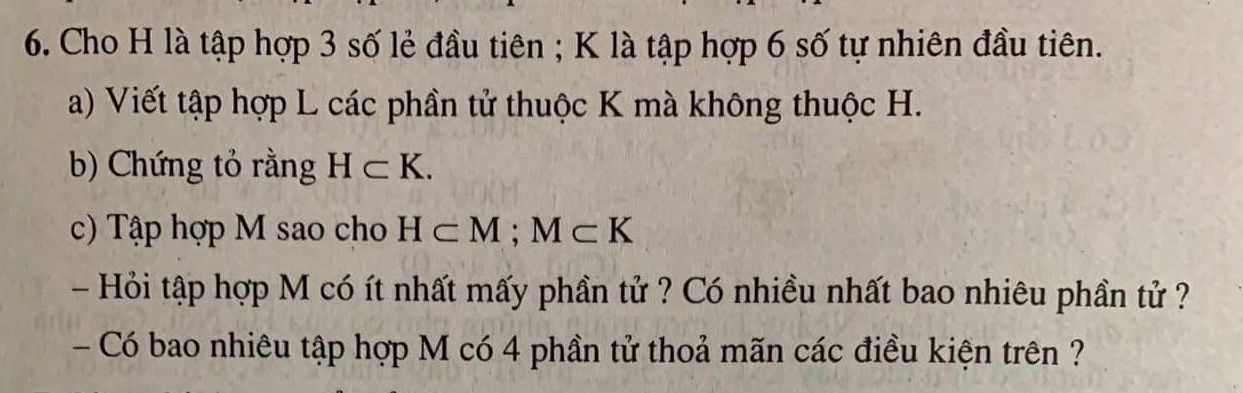

-- Number of words: 58


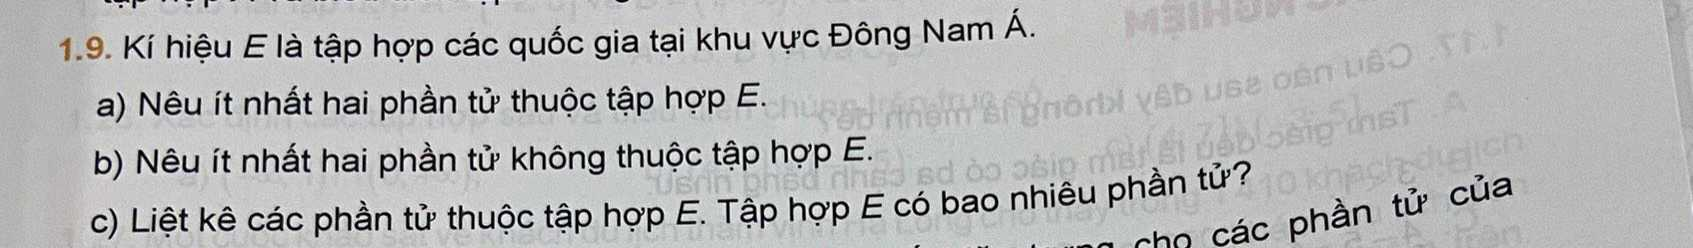

************

PAIRS: 4 - Jaccard score: 1.0
-- Number of words: 24


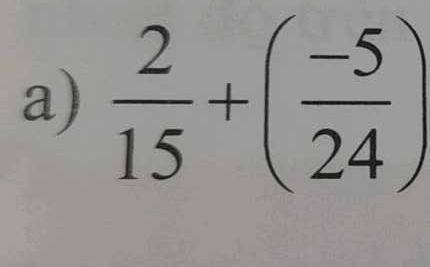

-- Number of words: 24


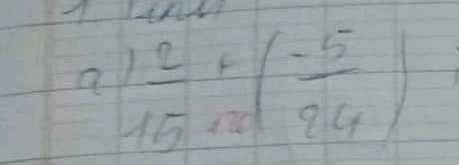

-- Number of words: 24


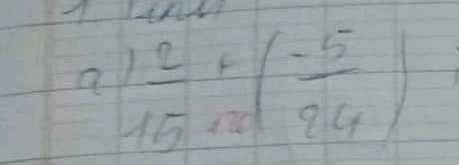

************

PAIRS: 5 - Jaccard score: 1.0
-- Number of words: 132


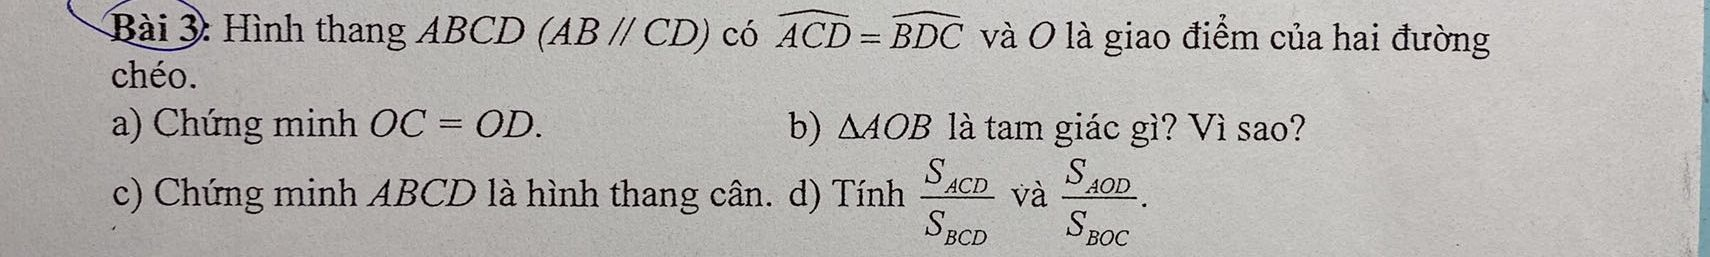

-- Number of words: 132


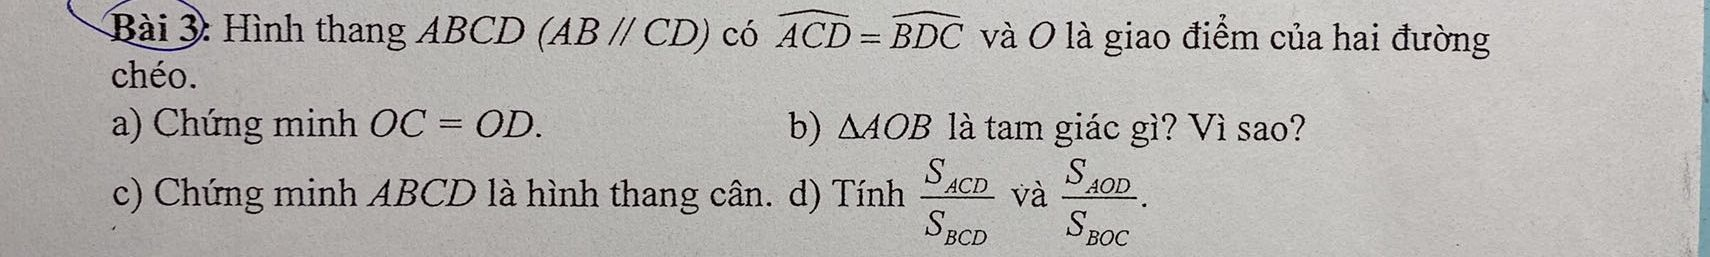

-- Number of words: 132


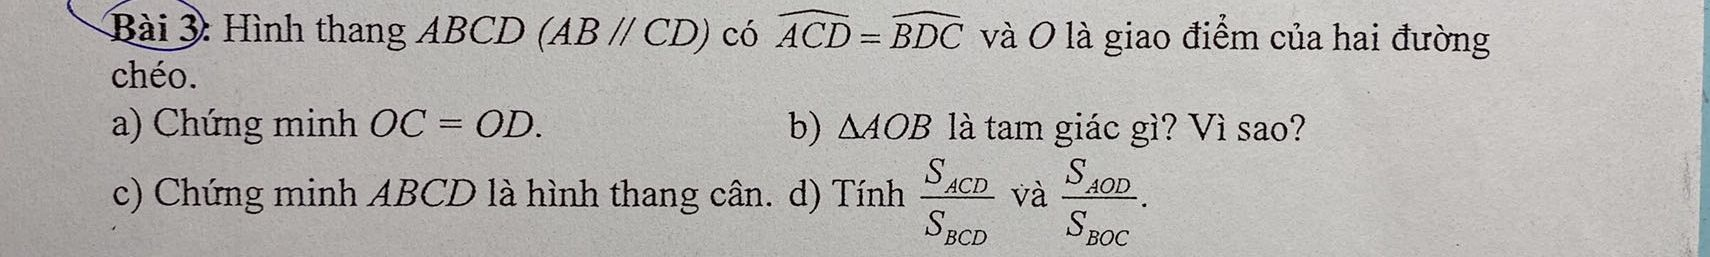

************

PAIRS: 6 - Jaccard score: 1.0
-- Number of words: 53


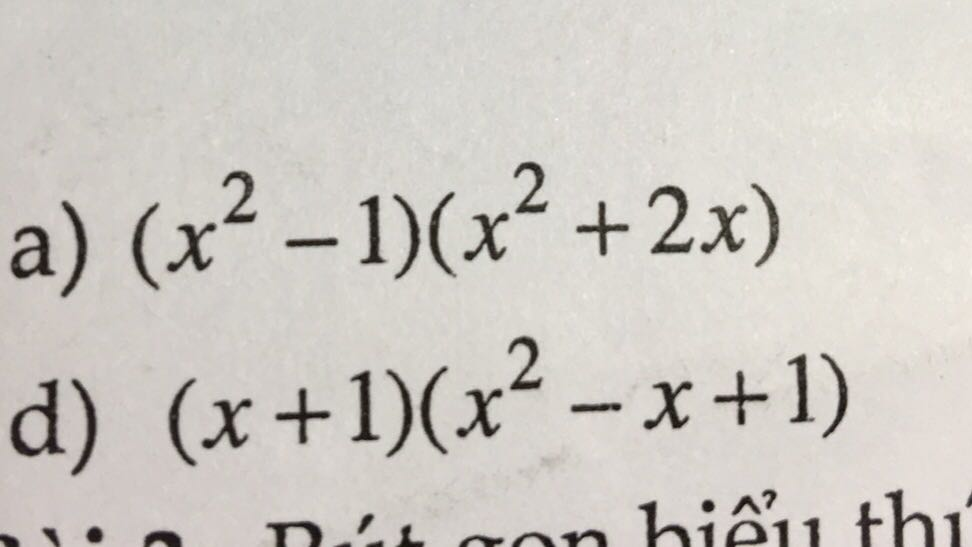

-- Number of words: 112


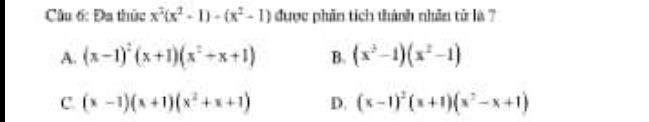

-- Number of words: 53


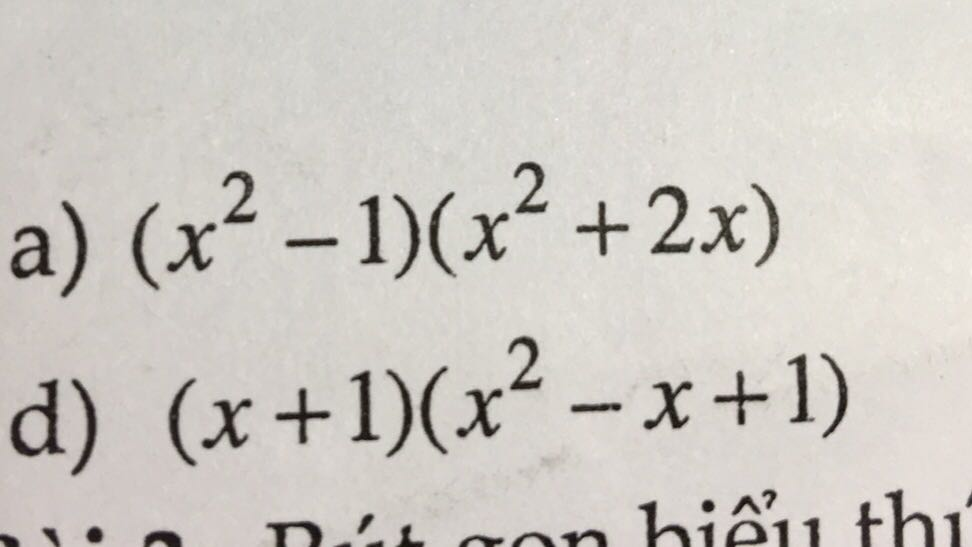

************

PAIRS: 7 - Jaccard score: 1.0
-- Number of words: 81


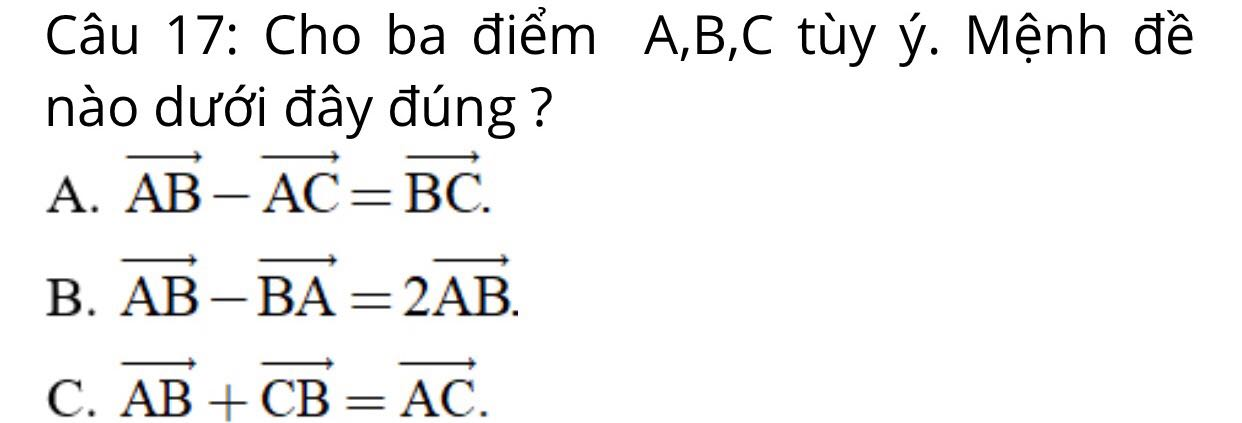

-- Number of words: 81


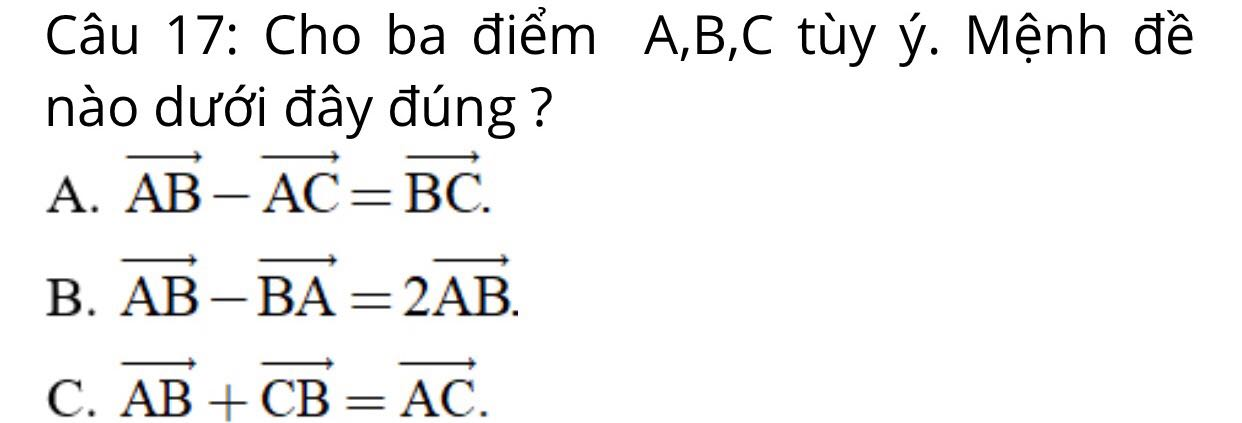

-- Number of words: 81


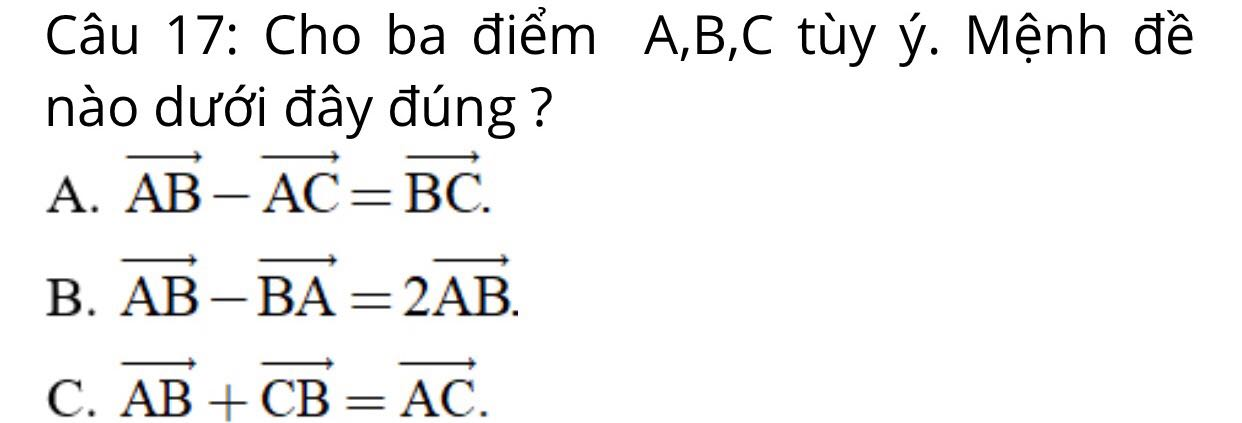

************

PAIRS: 8 - Jaccard score: 1.0
-- Number of words: 31


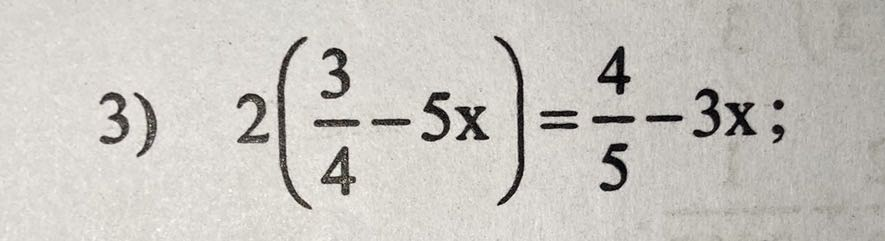

-- Number of words: 543


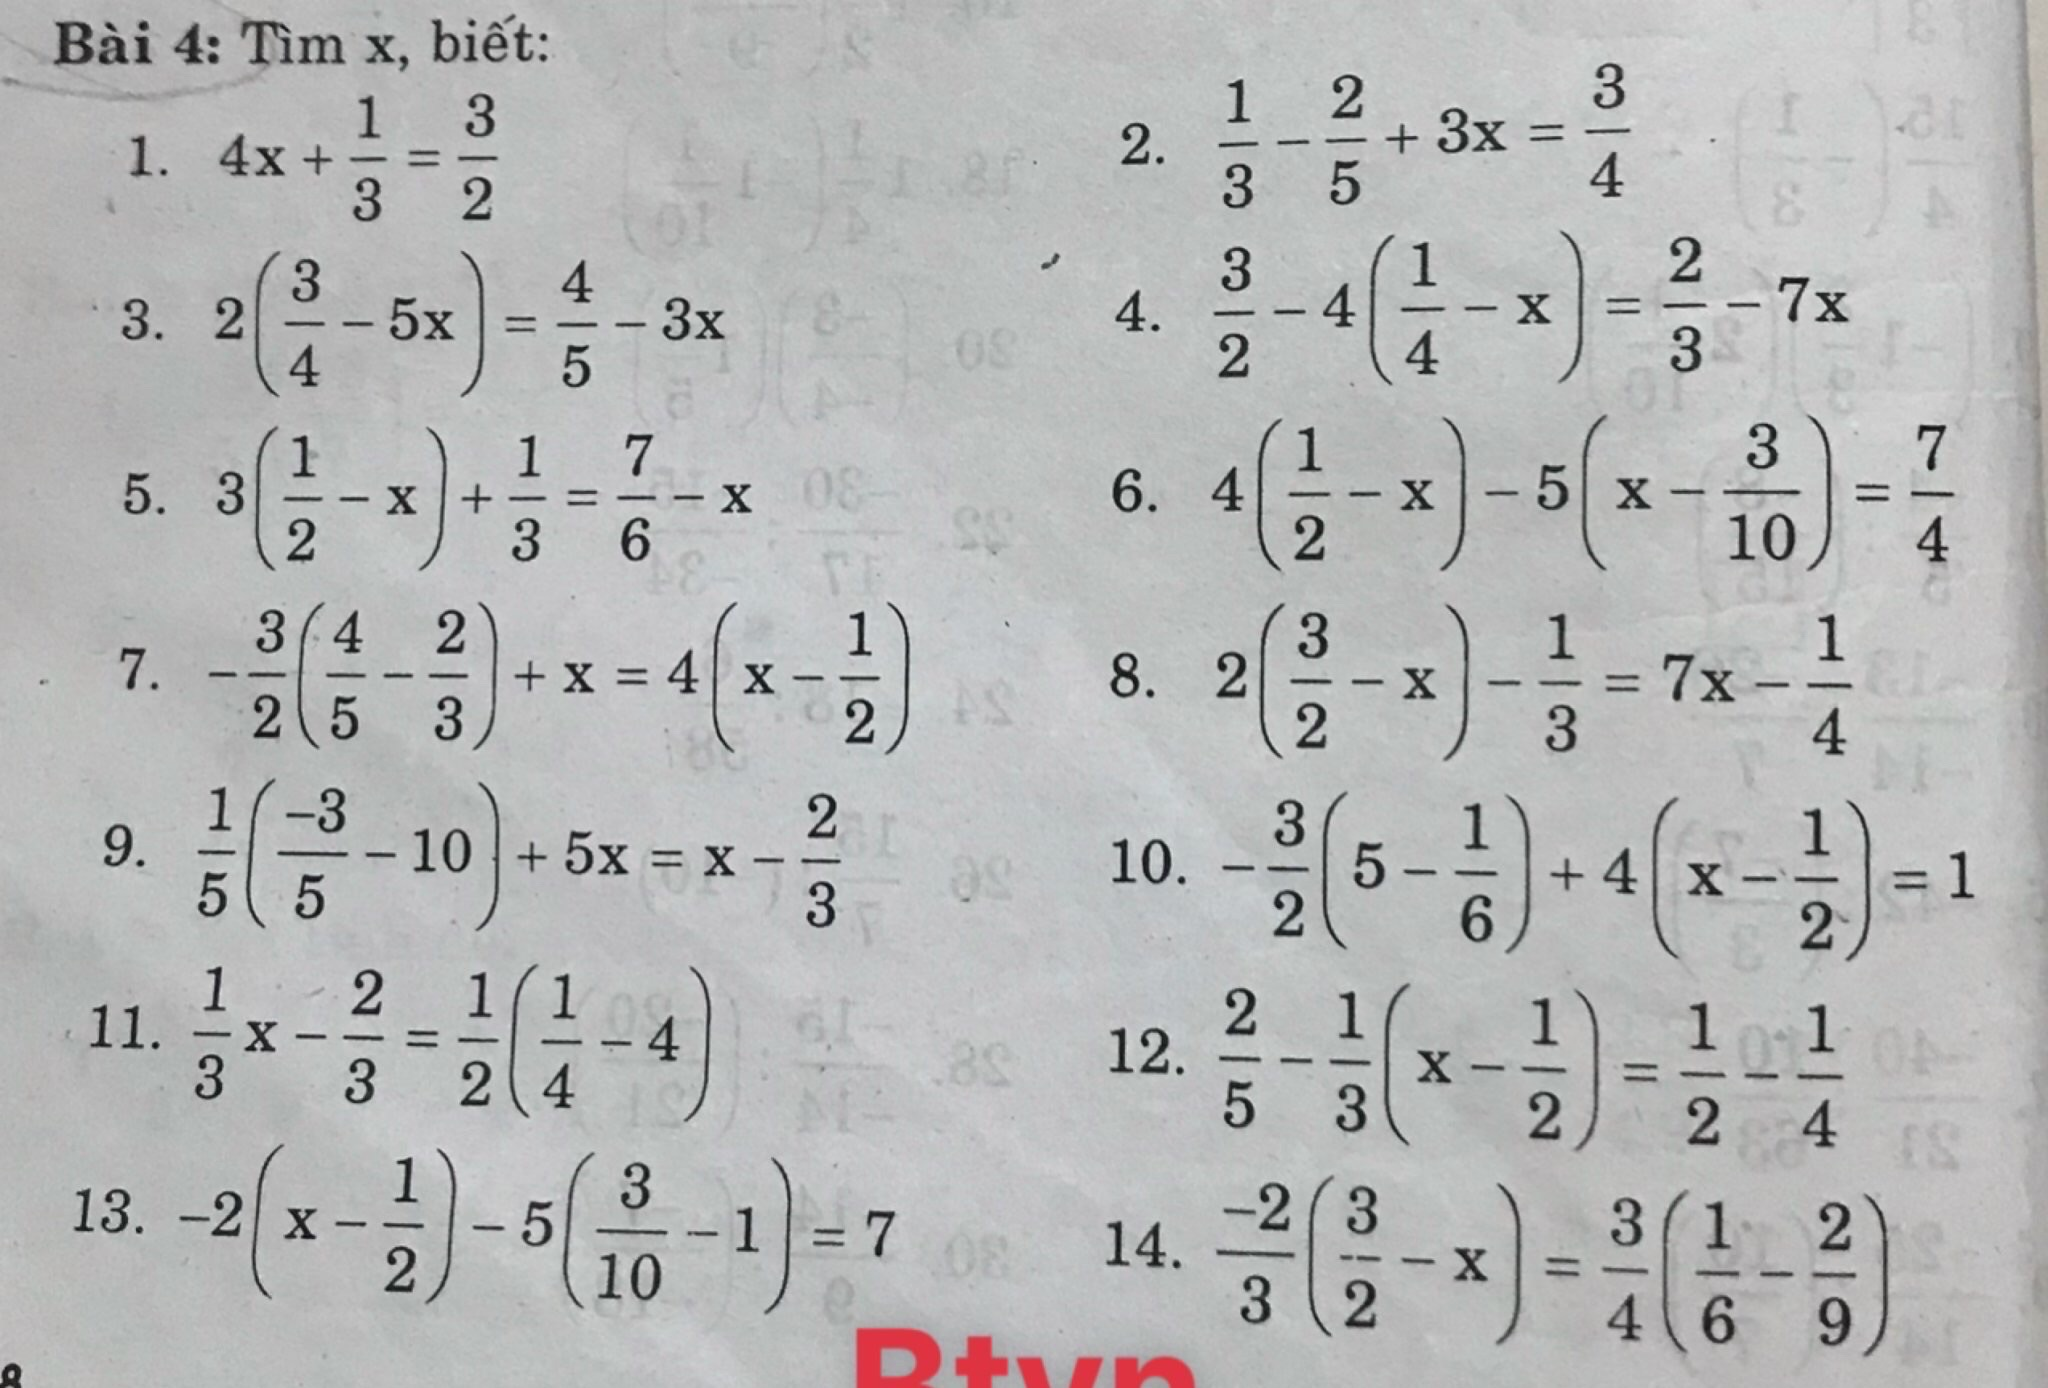

-- Number of words: 31


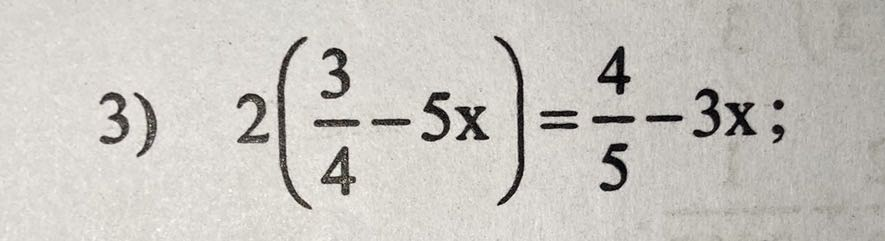

************

PAIRS: 9 - Jaccard score: 1.0
-- Number of words: 114


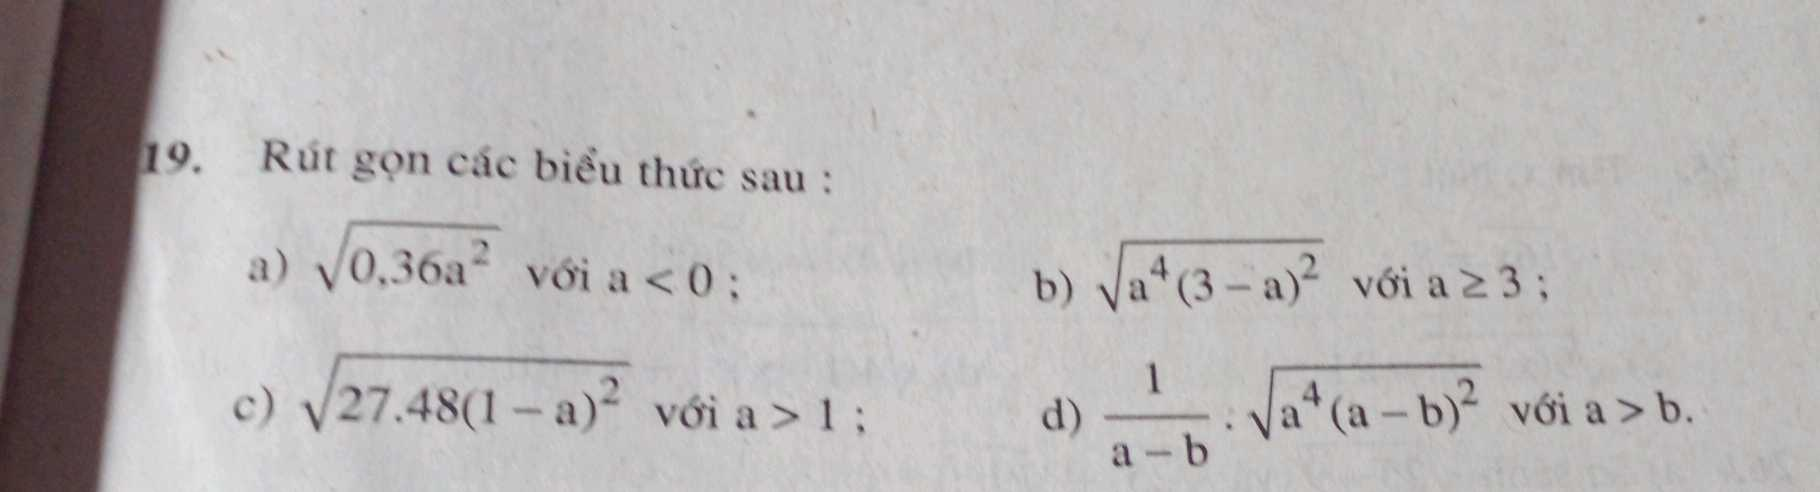

-- Number of words: 83


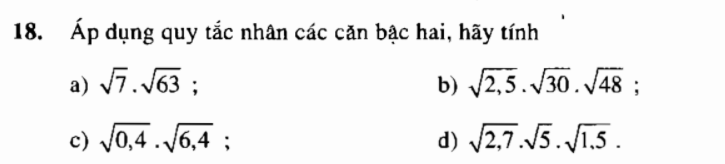

-- Number of words: 115


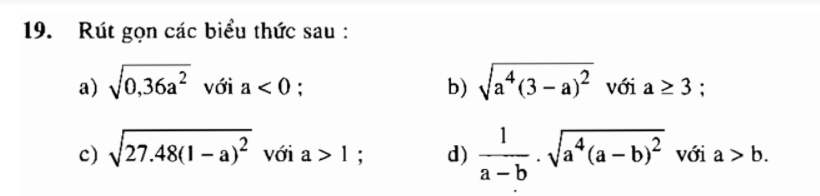

************

PAIRS: 10 - Jaccard score: 1.0
-- Number of words: 45


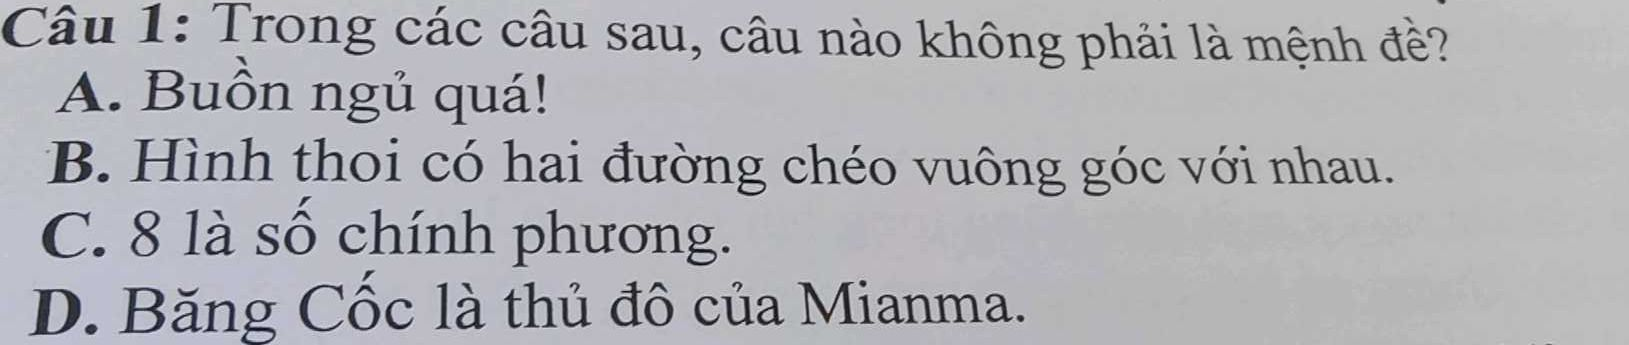

-- Number of words: 73


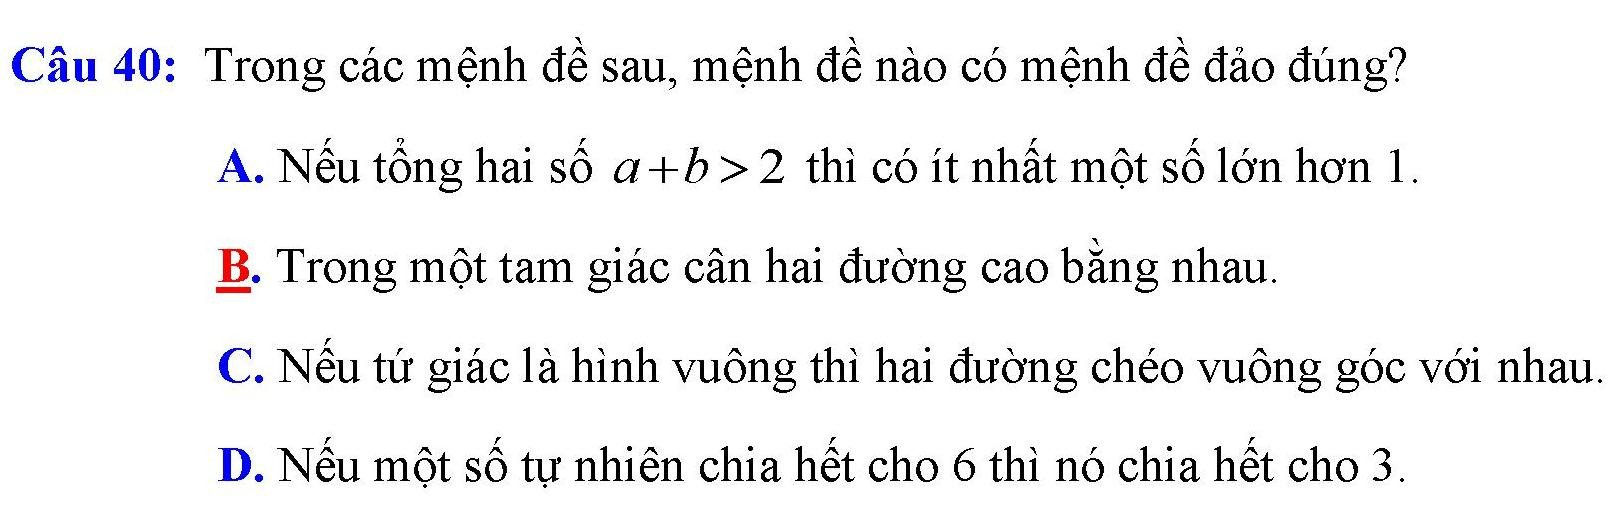

-- Number of words: 45


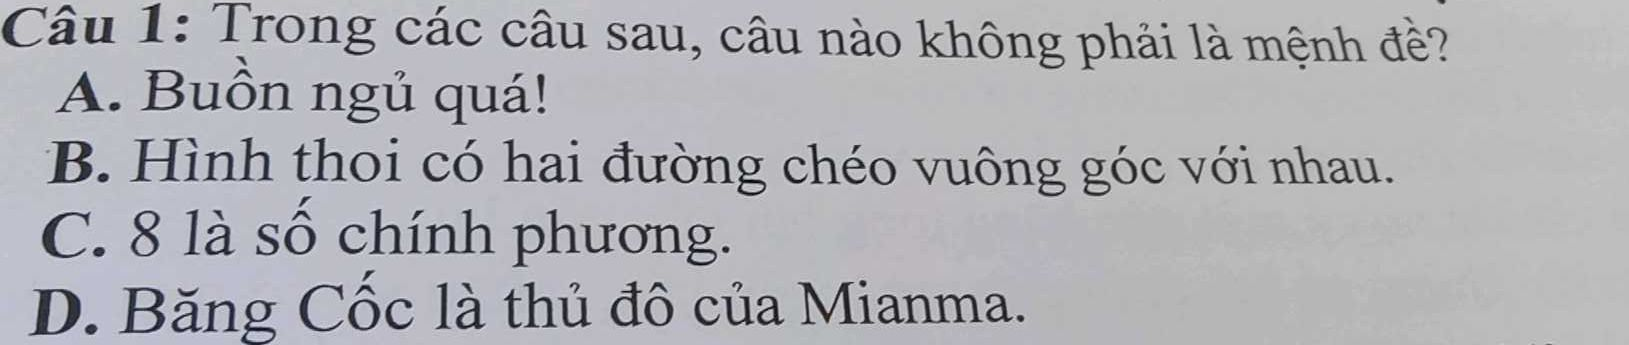

************

PAIRS: 11 - Jaccard score: 1.0
-- Number of words: 89


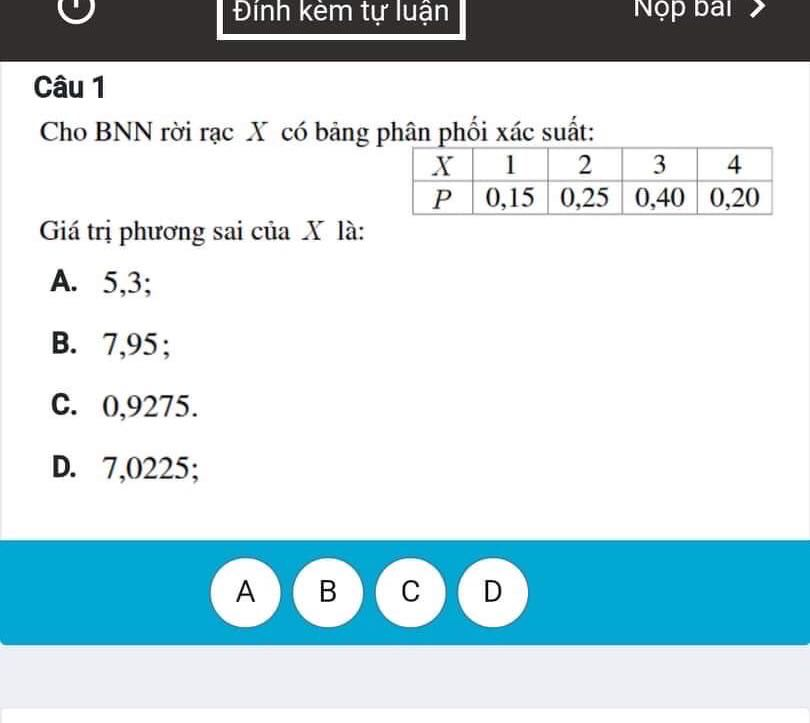

-- Number of words: 137


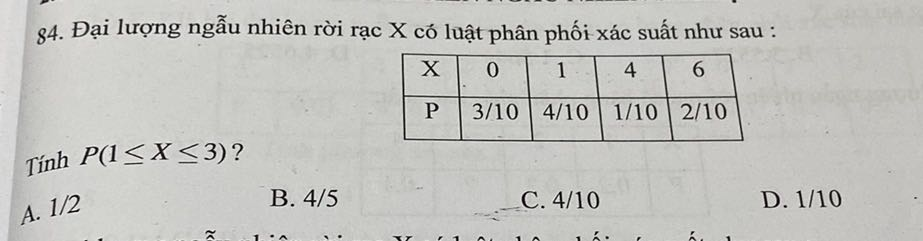

-- Number of words: 89


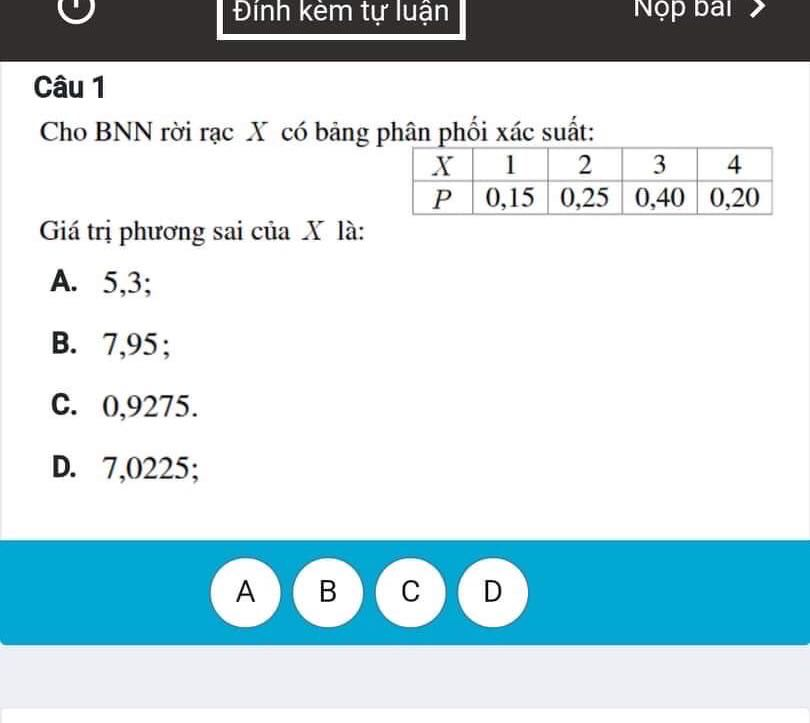

************



In [23]:
idx = 0
end = 10

for url1, url2 in zip(df_not['Question Image'].values, df_not['jc_image'].values):
    print('PAIRS: {} - Jaccard score: {}'.format(idx + 1, df_not['jc_score'].values[idx]))
    print('-- Number of words:', df_not['word_count_lookup'].values[idx])
    img0 = Disp.Image(requests.get(df_not['Lookup Image'].values[idx]).content)
    display(img0)
    print('-- Number of words:', df_not['word_count_question'].values[idx])
    img1 = Disp.Image(requests.get(url1).content)
    display(img1)
    print('-- Number of words:', df_not['jc_word_count_question'].values[idx])
    img2 = Disp.Image(requests.get(url2).content)
    display(img2)
    print('************')
    print()
    idx += 1
    if idx > end:
        break